In [83]:
# Import Gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
# ls

In [85]:
# cd drive/MyDrive

In [86]:
#import libraries
import os
import cv2
import numpy as np
from IPython.display import display, Javascript
from google.colab.patches import cv2_imshow
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from tensorflow.keras.utils import img_to_array
# from tensorflow.keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")
imagegen = ImageDataGenerator()
import matplotlib.pyplot as plt

In [87]:
#import dataset
train = imagegen.flow_from_directory("Helmet_Dataset/Train/", class_mode="categorical", shuffle=True, batch_size=2, target_size=(50, 50))
test = imagegen.flow_from_directory("Helmet_Dataset/Test/", class_mode="categorical", shuffle=True, batch_size=2, target_size=(50, 50))
val = imagegen.flow_from_directory("Helmet_Dataset/Val/", class_mode="categorical", shuffle=True, batch_size=2, target_size=(50, 50))

Found 12 images belonging to 2 classes.
Found 8 images belonging to 2 classes.
Found 4 images belonging to 2 classes.


In [88]:
#import pre trained VGG 16 Model
pre_trained_model = tf.keras.applications.VGG16(input_shape=(50, 50, 3), include_top=False, weights="imagenet")

In [89]:
#display layers
for layer in pre_trained_model.layers:
  print(layer.name)
  layer.trainable = False

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [90]:
#Modify last layer
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(2, activation='sigmoid')(x)

In [91]:
#Load model
model = tf.keras.Model(pre_trained_model.input, x)

In [92]:
#compile model
model.compile(optimizer='adam', loss=tf.keras.losses.binary_crossentropy, metrics=['accuracy'], run_eagerly=True)

In [93]:
#model characteristics
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50, 50, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 50, 50, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 50, 50, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 25, 25, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 25, 25, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 25, 25, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0   

In [94]:
#model training
enet_classifier = model.fit(train, steps_per_epoch=(120//18), epochs = 40, validation_data=val, validation_steps=(19//18), batch_size = 2, verbose = 1)

Epoch 1/40
6/6 [==============================] - 2s 150ms/step - loss: 4.0442 - accuracy: 0.5833 - val_loss: 13.0200 - val_accuracy: 0.0000e+00
Epoch 2/40
6/6 [==============================] - 1s 116ms/step - loss: 5.9483 - accuracy: 0.7500 - val_loss: 4.0635 - val_accuracy: 0.5000
Epoch 3/40
6/6 [==============================] - 1s 93ms/step - loss: 6.3300 - accuracy: 0.8333 - val_loss: 9.0601 - val_accuracy: 0.0000e+00
Epoch 4/40
6/6 [==============================] - 1s 95ms/step - loss: 1.4938 - accuracy: 1.0000 - val_loss: 7.8368 - val_accuracy: 0.5000
Epoch 5/40
6/6 [==============================] - 1s 93ms/step - loss: 3.6081 - accuracy: 0.9167 - val_loss: 3.4626 - val_accuracy: 0.5000
Epoch 6/40
6/6 [==============================] - 1s 97ms/step - loss: 1.6947 - accuracy: 1.0000 - val_loss: 3.8106 - val_accuracy: 0.5000
Epoch 7/40
6/6 [==============================] - 1s 90ms/step - loss: 2.6631 - accuracy: 0.8333 - val_loss: 5.4177 - val_accuracy: 0.5000
Epoch 8/40
6/6 [

In [95]:
#model result - print accuracy and loss
result = model.evaluate(test, batch_size=2)
print("[Loss, Accuracy] = ", result)

4/4 [==============================] - 0s 68ms/step - loss: 1.1010 - accuracy: 0.8750
[Loss, Accuracy] =  [1.1010398864746094, 0.875]


In [96]:
#testing existing image
test_img = '/content/test_image.jpg'

In [97]:
#test prediction
test = cv2.imread(test_img)
test = cv2.resize(test, (50, 50))
test = np.array(test)
test = np.expand_dims(test, axis=0)
print("Shape of Validation Data: ", test.shape)
pred = model.predict(test)

Shape of Validation Data:  (1, 50, 50, 3)
1/1 [==============================] - 0s 43ms/step


In [98]:
#class prediction
def pred_img(index):
    if index == 1:
        return 'Helmet Detected'
    else:
        return 'No Helmet Detected'

In [99]:
#test image prediction result
pred = np.array(pred.tolist())[0]
index = pred.tolist().index(max(pred))
# print(index)
print("Result from Input Test Image:", pred_img(index))
print("Accuracy = ", max(pred))

Result from Input Test Image: No Helmet Detected
Accuracy =  0.9999749660491943


In [100]:
#live camera image capture function
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [109]:
# Function Call
original_image = take_photo()

<IPython.core.display.Javascript object>

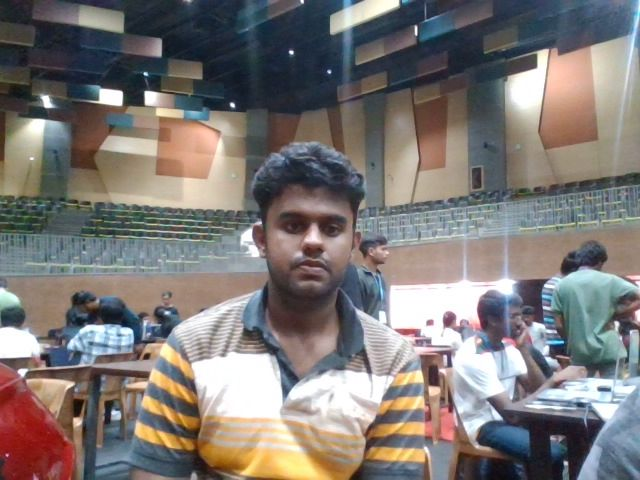

In [110]:
#displaying captured image
img = cv2.imread(original_image)
cv2_imshow(img)

In [111]:
#captured image prediction
img = cv2.resize(img, (50, 50))
img = np.array(img)
img = np.expand_dims(img, axis=0)
print("Shape of Validation Data: ", img.shape)
res = model.predict(img)

Shape of Validation Data:  (1, 50, 50, 3)
1/1 [==============================] - 0s 76ms/step


In [112]:
#displaying result of captured image
res = np.array(pred.tolist())
index = res.tolist().index(max(res))
print("Input Test Image falls under the Category:", pred_img(index))
print("Accuracy = ", max(res))

Input Test Image falls under the Category: No Helmet Detected
Accuracy =  0.9999749660491943
